## CS146 Final Project 
### Modeling and forecasting atmospheric CO2 from 1958 into the future 
Marcela Radilla Deloya <br> CS146 <br> Fall 2020 

In this project, the Weekly Manua Loa dataset from the Scripps Institue CO2 program will be used to create a statistical model that 1) explains the dataset well and 2) will be used to forecast CO2 measurements between 2020 and the start of 2060. 


###Importing relevant libraries

In [4]:
#importing relevant libraries 
import pystan
import numpy as np
from scipy import stats as sts 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy import signal
from datetime import datetime,date 
sns.set_theme(style="darkgrid")

###  Data loading 

In [5]:
#importing the dataset 
df=pd.read_csv('/content/drive/MyDrive/Fall 2020/Manua_Loa - Sheet1.csv')

In [6]:
df

Date     CO2
0     29/03/1958  316.19
1     05/04/1958  317.31
2     12/04/1958  317.69
3     19/04/1958  317.58
4     26/04/1958  316.48
...          ...     ...
3194  31/10/2020  411.92
3195  07/11/2020  412.37
3196  14/11/2020  412.67
3197  21/11/2020  412.98
3198  28/11/2020  414.32

[3199 rows x 2 columns]

In [7]:
example2=df.iloc[1,0]
example2

'05/04/1958'

In [8]:
example=df.iloc[0,0]
print(example)
datetime.strptime(example,"%d/%m/%Y")

29/03/1958


datetime.datetime(1958, 3, 29, 0, 0)

In [9]:
#turning data in date format to number of days since first measurement 
def days_difference(date1,date2):
  #%Y for
  date1=datetime.strptime(date1,"%d/%m/%Y")
  date2=datetime.strptime(date2,"%d/%m/%Y")
  return abs((date2-date1).days)

In [10]:
days_difference(example,example)

0

In [11]:
#we will add a column to the dataset to represent the number of days since the first measurement 
#getting all dates
dates=df['Date']
dates_len=len(dates)
df['Days']=[days_difference(dates[i],dates[0]) for i in range(dates_len)]
df['Dates']=[datetime.strptime(df['Date'][i],"%d/%m/%Y") for i in range(dates_len)]
df

Date     CO2   Days      Dates
0     29/03/1958  316.19      0 1958-03-29
1     05/04/1958  317.31      7 1958-04-05
2     12/04/1958  317.69     14 1958-04-12
3     19/04/1958  317.58     21 1958-04-19
4     26/04/1958  316.48     28 1958-04-26
...          ...     ...    ...        ...
3194  31/10/2020  411.92  22862 2020-10-31
3195  07/11/2020  412.37  22869 2020-11-07
3196  14/11/2020  412.67  22876 2020-11-14
3197  21/11/2020  412.98  22883 2020-11-21
3198  28/11/2020  414.32  22890 2020-11-28

[3199 rows x 4 columns]

### Initial data visualization

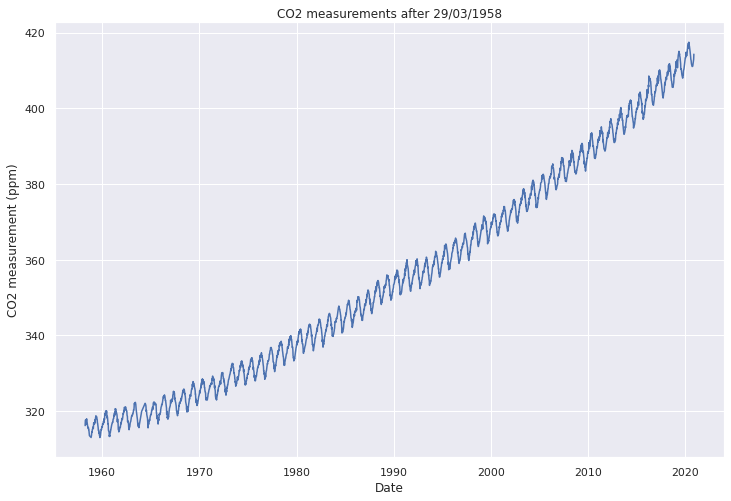

In [12]:
#seaborn.set()
day=df['Days']
co2=df['CO2']
dates=df['Dates']
#plotting the data 
plt.figure(figsize=(12,8))
plt.plot(dates,co2)
#plt.xticks()
plt.title('CO2 measurements after 29/03/1958')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
plt.show()

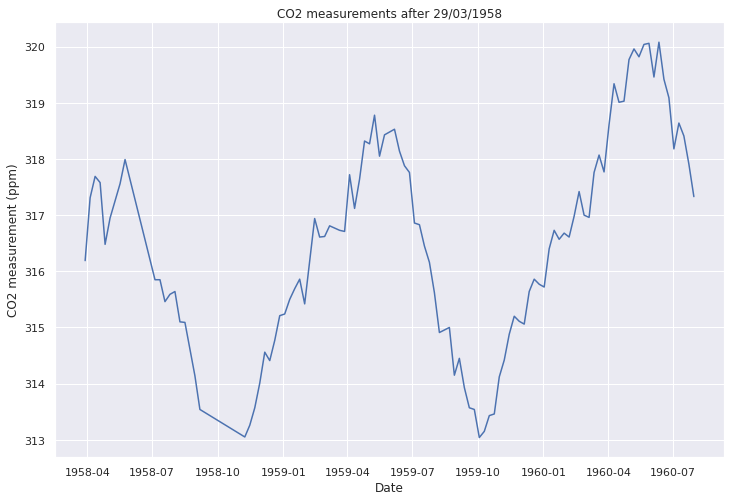

In [13]:
#plotting some close-ups of the data 
day=df['Days'][0:104]
co2=df['CO2'][0:104]
dates=df['Dates'][0:104]
#plotting the data 
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(dates,co2)
#plt.xticks(np.arange(0,801,50))
plt.title('CO2 measurements after 29/03/1958')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
ax.xaxis_date()
plt.show()

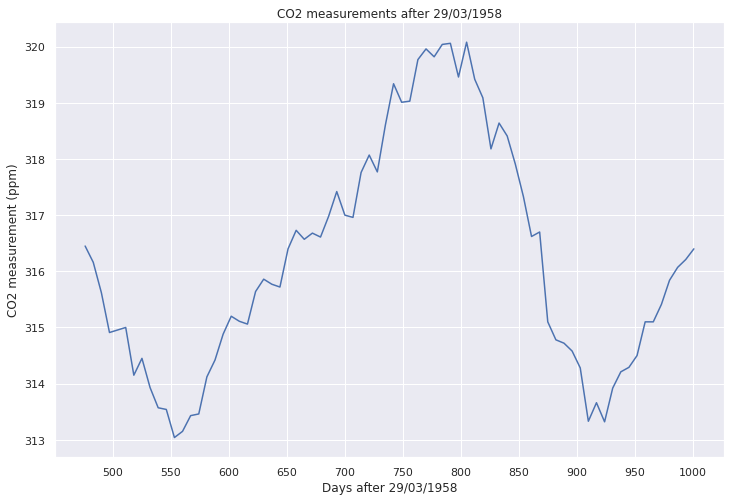

In [14]:
#plotting another close-up of the data from 50 to 125 measurements after the first one 
#in this close up we can observe how we have a 365 day period
#plotting a close-up of the data, from 
day=df['Days']
co2=df['CO2']
plt.figure(figsize=(12,8))
plt.plot(day[50:125],co2[50:125])
plt.xticks(np.arange(500,1001,50))
plt.title('CO2 measurements after 29/03/1958')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

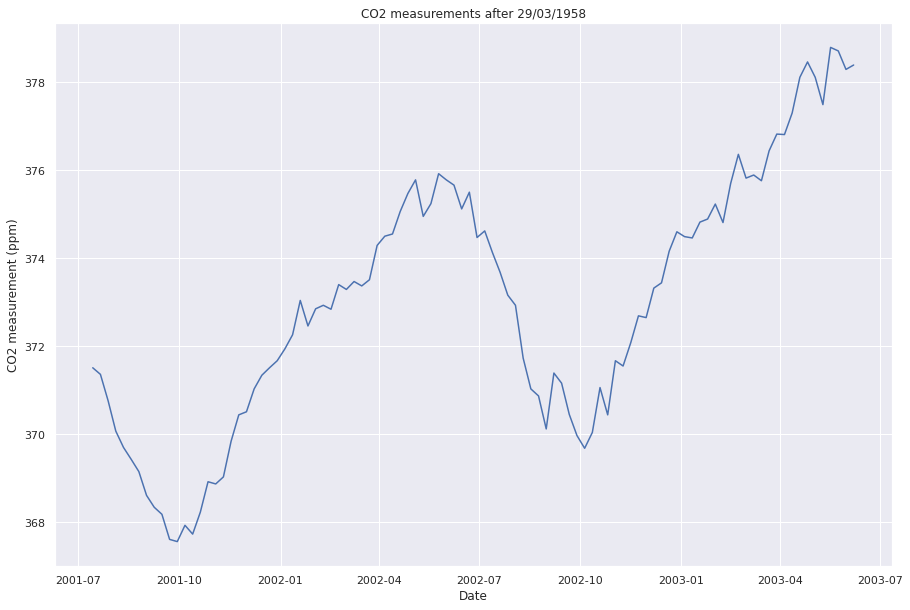

In [15]:
#another close up of the data for the first 300 measurements
day=df['Days'][2200:2300]
co2=df['CO2'][2200:2300]
dates=df['Dates'][2200:2300]
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(dates,co2)
plt.title('CO2 measurements after 29/03/1958')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Date')
ax.xaxis_date()
plt.show()

In [16]:
np.mean(co2)

373.0155

### Implementing the suggested linear model 


Our model should contain three elements:  
* An overall trend
* Seasonal variation 
* Noise  
The suggested linear model models them as follows: 
* Long term trend is linear: $c_0+c_1t$
* Seasonal variation (every $365.25$ days): $c_2 cos(2\pi/365.5+c_3)$
* Noise: coming from a Gaussian with mean $0$ and standard deviation $c_4$ 
These components give us the following likelihood function: 
$$p(x_t|\theta)=N(c_0+c_1t+c_2cos(2\pi/365.5+c_3),c_4^2)$$
 

### Visualizing the priors 

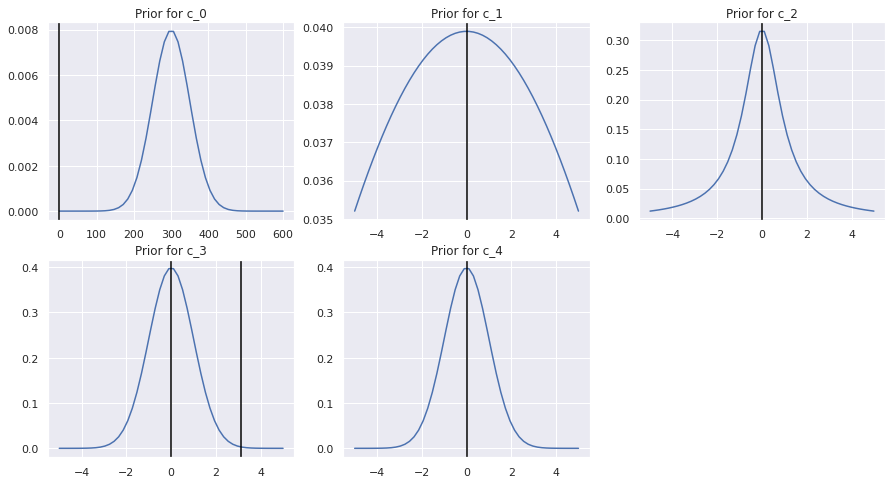

In [17]:
#plotting the priors 
plt.figure(figsize=(15,8))
prior_c0=sts.norm.pdf(np.linspace(0,600),300,50)
prior_c1=sts.norm.pdf(np.linspace(-5,5),0,10)
prior_c2=sts.cauchy.pdf(np.linspace(-5,5),0,1)
prior_c3=sts.norm.pdf(np.linspace(-5,5),0,1)
prior_c4=sts.norm.pdf(np.linspace(-5,5),0,1)
plt.subplot(2,3,1)
plt.plot(np.linspace(0,600),prior_c0)
plt.axvline(x=0,color='black')
plt.title('Prior for c_0')
plt.subplot(2,3,2)
plt.plot(np.linspace(-5,5),prior_c1)
plt.axvline(x=0,color='black')
plt.title('Prior for c_1')
plt.subplot(2,3,3)
plt.plot(np.linspace(-5,5),prior_c2)
plt.axvline(x=0,color='black')
plt.title('Prior for c_2')
plt.subplot(2,3,4)
plt.plot(np.linspace(-5,5),prior_c3)
plt.axvline(x=np.pi,color='black')
plt.axvline(x=0,color='black')
plt.title('Prior for c_3')
plt.subplot(2,3,5)
plt.plot(np.linspace(-5,5),prior_c4)
plt.axvline(x=0,color='black')
plt.title('Prior for c_4')
plt.show()

### Setting up the linear model in STAN

In [18]:
stan_code_linear= """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

  int<lower=0> n; //number of observations 
  real<lower=0> co2[n]; // this establishes an n-sized array containing real values named co2 for the CO2 weekly measurements  
  int<lower=0> t[n]; // an array of length n containing ints for the number of days after the first measurement
  //t is our time variable as stated in the assignment description 

}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

  //Overall trend parameters
  real<lower=0> c_0; //y-intercept
  real<lower=0> c_1; //linear term 

  //Seasonal variation parameters 
  real<lower=0> c_2; //amplitude 
  real<lower=0,upper=pi()> c_3; //horizontal (phase) shift 


  //Noise parameters 
  real<lower=0> c_4; //standard deviation for Gaussian which provides us with the noise 
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.
model {
    //priors
    c_0~normal(300,50); //prior for y-intercept 
    c_1~normal(0,10); //prior for linear term (somewhat broad normal)
    c_2~cauchy(0,1); //prior for the amplitude (cauchy because I want to have enough density at the tails)
    c_3~normal(0,1);//prior for the phase shift 
    c_4~normal(0,1); //prior for the stdev for the noise coming from the Gaussian centered at 0 

    //likelihood 
    for (i in 1:n){
      co2[i]~normal(c_0+c_1*t[i]+c_2*cos((2*pi()*t[i]/365.25)+c_3),c_4);
    }
}
"""

In [19]:
stan_model_linear=pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49f7387c51d7f8df0fec895efd32eefc NOW.


In [20]:
#grabbing things from the dataframe again 
time=df['Days'].values
measurements=df['CO2'].values
measurements

array([316.19, 317.31, 317.69, ..., 412.67, 412.98, 414.32])

In [21]:
#creating a dictionary to provide stan with the data 
data={
    'n':len(time),
    'co2':measurements,
    't':time
}
data

{'co2': array([316.19, 317.31, 317.69, ..., 412.67, 412.98, 414.32]),
 'n': 3199,
 't': array([    0,     7,    14, ..., 22876, 22883, 22890])}

### STAN output for the linear model

In [22]:
stan_linear_results=stan_model_linear.sampling(data=data,seed=12213)
print(stan_linear_results)

Inference for Stan model: anon_model_49f7387c51d7f8df0fec895efd32eefc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0  305.72  2.2e-3   0.15 305.43 305.62 305.72 305.82 306.01   4211    1.0
c_1  4.4e-3  1.7e-7 1.1e-5 4.3e-3 4.3e-3 4.4e-3 4.4e-3 4.4e-3   4177    1.0
c_2    2.58  2.2e-3    0.1   2.38   2.51   2.58   2.65   2.78   2092    1.0
c_3  3.2e-3  6.4e-5 3.2e-3 6.4e-5 9.1e-4 2.2e-3 4.4e-3   0.01   2494    1.0
c_4    4.02  1.1e-3   0.05   3.92   3.98   4.02   4.05   4.12   1993    1.0
lp__  -6066    0.05   1.71  -6071  -6067  -6066  -6065  -6064   1252    1.0

Samples were drawn using NUTS at Wed Dec 16 05:32:54 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


**Initial interpretation of the STAN output for the suggested linear model** <br>
As discussed in class, n_eff refers to the effective sample size, this is an estimation for the amount of samples, out of the total amount, are independent samples. Numbers below a couple hundred independent samples are an indicator that STAN is not being able to generate independent samples. Rhat is a measure of how well the chains are mixing, it is calculated by dividing the variance of samples from one chain, over the variance of samples from all chains, numbers away from 1.0 indicate that our chains are likely not mixing properly. 

As we can see in the results above, the chains for all parameters are mixing properly, and we have good numbers for the effective sample size, over a thousand independent samples for each parameter. 
We still need to look at the uncertainty of this model and create improvements on it. We will now visualize sample autocorrelation from this model, and pair plots, to look for improvement areas. 

In [23]:
samples_linear=stan_linear_results.extract()

In [24]:
#autocorrelation plot code  
#taken from the preclass work for session 14.1  
#https://gist.github.com/cscheffler/c0457a83bb7af0390036b6efd84b934c
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''    
    plt.acorr(x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

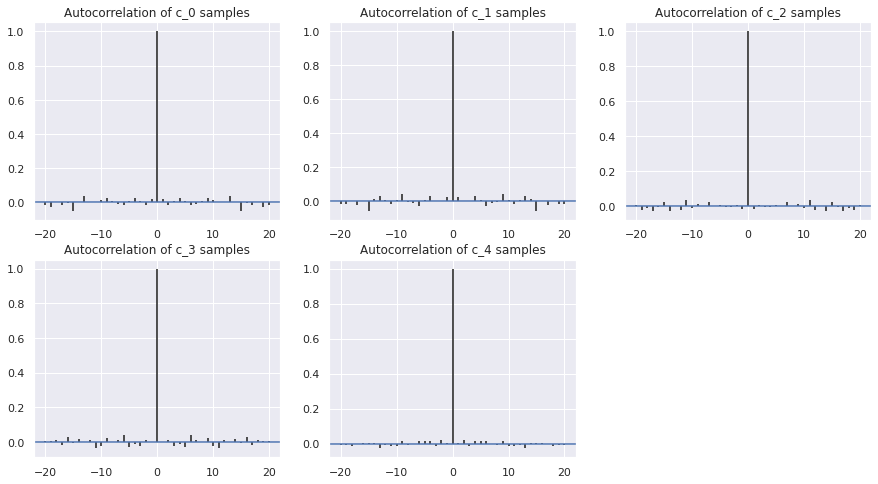

In [25]:
#plotting the autocorrelations 
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plot_acf(samples_linear['c_0'])
plt.title('Autocorrelation of c_0 samples')
plt.subplot(2,3,2)
plot_acf(samples_linear['c_1'])
plt.title('Autocorrelation of c_1 samples')
plt.subplot(2,3,3)
plot_acf(samples_linear['c_2'])
plt.title('Autocorrelation of c_2 samples')
plt.subplot(2,3,4)
plot_acf(samples_linear['c_3'])
plt.title('Autocorrelation of c_3 samples')
plt.subplot(2,3,5)
plot_acf(samples_linear['c_4'])
plt.title('Autocorrelation of c_4 samples')
plt.show()

As we can see above, autocorrelation plots for the first two parameters look fine (we only have a large central bar which represents the comparison of every sample with itself, and then we have smaller bars to the sides), but not for the rest of our parameters.

In [26]:
#pair plots code 
#also adapted from pcw code for session 14.1 
def pairplot(samples,parameters,s):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    sns.pairplot(df, height=s, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


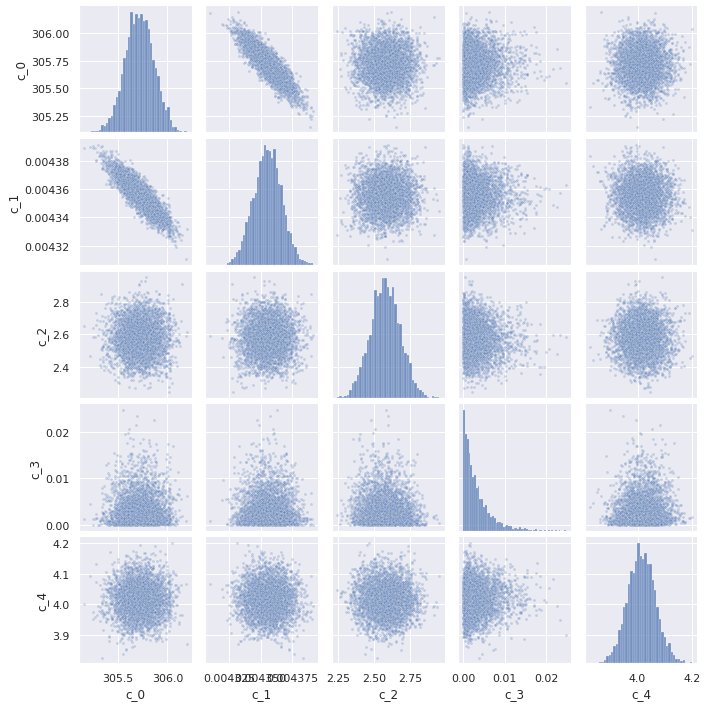

In [28]:
linear_params=['c_0','c_1','c_2','c_3','c_4']
pairplot(samples_linear,linear_params,2)

Visualizing individual histograms for the samples 

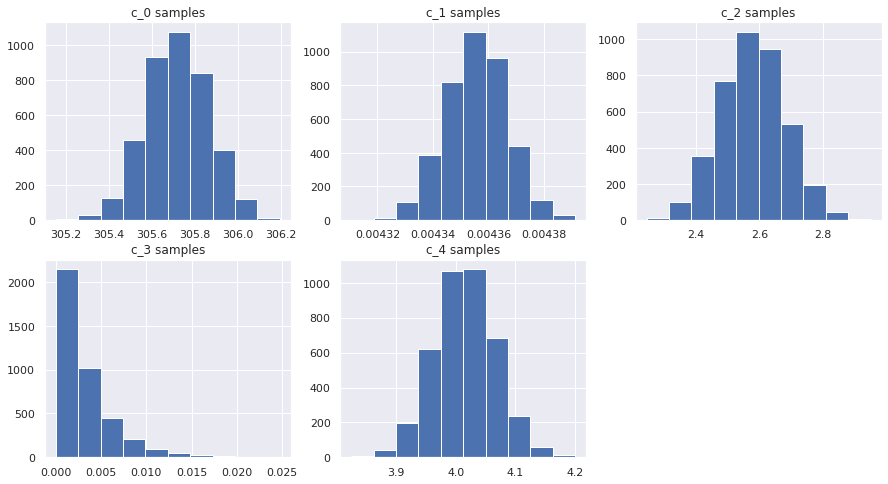

In [29]:
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plt.hist(samples_linear['c_0'])
plt.title('c_0 samples')
plt.subplot(2,3,2)
plt.hist(samples_linear['c_1'])
plt.title('c_1 samples')
plt.subplot(2,3,3)
plt.hist(samples_linear['c_2'])
plt.title('c_2 samples')
plt.subplot(2,3,4)
plt.hist(samples_linear['c_3'])
plt.title('c_3 samples')
plt.subplot(2,3,5)
plt.hist(samples_linear['c_4'])
plt.title('c_4 samples')
plt.show()

### STAN output visualization

We will now extract the mean of the samples for each parameter and look at how this model fits the observed data. 

In [30]:
means=[np.mean(samples_linear[param]) for param in linear_params]
a=np.asarray(linear_params)
means=np.asarray(means)
means

array([3.05717780e+02, 4.35559418e-03, 2.57902962e+00, 3.18853470e-03,
       4.01544496e+00])

In [31]:
d=np.stack((a,means),axis=1)
d

array([['c_0', '305.717780414401'],
       ['c_1', '0.004355594179316636'],
       ['c_2', '2.579029623349561'],
       ['c_3', '0.003188534704681637'],
       ['c_4', '4.015444955065311']], dtype='<U32')

In [32]:
linear_lower=[np.percentile(samples_linear[param],2.5) for param in linear_params]
linear_lower=np.asarray(linear_lower)
linear_upper=[np.percentile(samples_linear[param],97.5) for param in linear_params]
linear_upper=np.asarray(linear_upper)
print(linear_lower)
print(linear_upper)

[3.05428760e+02 4.33402840e-03 2.37839653e+00 6.67055277e-05
 3.91661327e+00]
[3.06006328e+02 4.37711658e-03 2.77891254e+00 1.17786299e-02
 4.11873535e+00]


In [33]:
len(time)

3199

In [34]:
for i in range(5):
  print(f'Parameter:{linear_params[i]} mean:{means[i]}, lower:{linear_lower[i]},upper:{linear_upper[i]}')

Parameter:c_0 mean:305.717780414401, lower:305.42876020969624,upper:306.0063276966924
Parameter:c_1 mean:0.004355594179316636, lower:0.0043340283969609894,upper:0.00437711657720298
Parameter:c_2 mean:2.579029623349561, lower:2.3783965269863265,upper:2.7789125372848167
Parameter:c_3 mean:0.003188534704681637, lower:6.670552767263236e-05,upper:0.011778629935811113
Parameter:c_4 mean:4.015444955065311, lower:3.916613269385666,upper:4.118735347649263


In [35]:
#c_0 is c[0]
#c_1 is c[1]
#c_2 is c[2]
#c_3 is c[3]
#c_4 is c[4]

#function is normal(c_0+c_1*t[i]+c_2*cos((2*pi()*t[i]/365.25)+c_3),c_4)

def linear_outputs(t,c):
  return np.array(sts.norm.rvs(c[0]+c[1]*t+c[2]*np.cos((2*np.pi*t/365.25)+c[3]),c[4]))

In [36]:
linear_mean_line=linear_outputs(time,means)
linear_upper_line=linear_outputs(time,linear_upper)
linear_lower_line=linear_outputs(time,linear_lower)

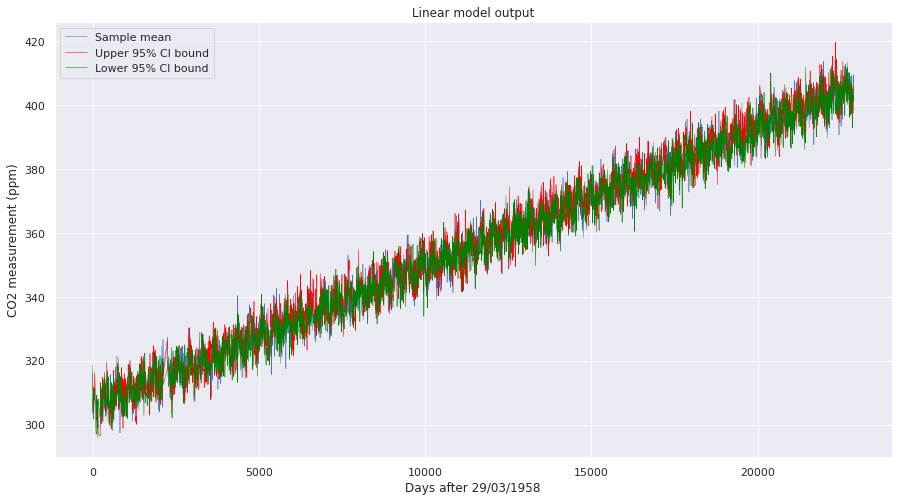

In [37]:
plt.figure(figsize=(15,8))
plt.plot(time,linear_mean_line,label='Sample mean',linewidth=0.5)
plt.plot(time,linear_upper_line,color='red',label='Upper 95% CI bound',linewidth=0.5)
plt.plot(time,linear_lower_line,color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.title('Linear model output')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

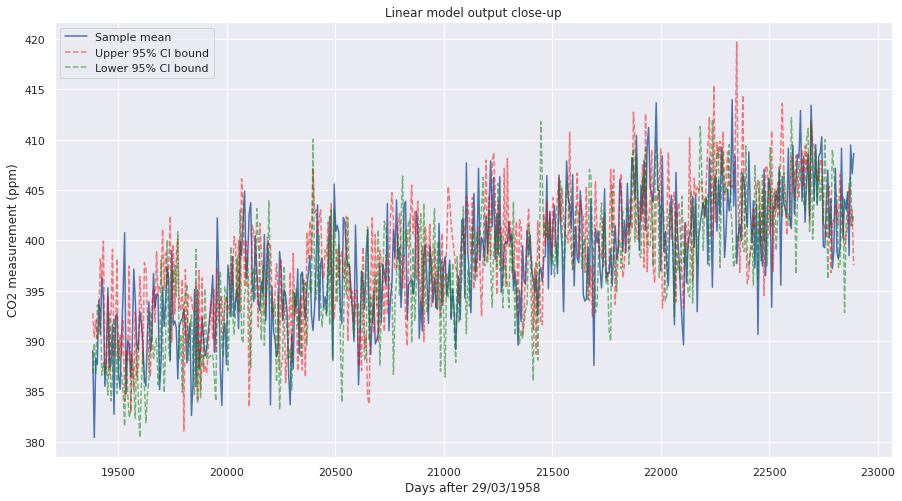

In [38]:
#we will now visualize a close-up of our model outout for the last 500 measurements in the dataset 
plt.figure(figsize=(15,8))
plt.plot(time[2700:3199],linear_mean_line[2700:3199],label='Sample mean',ls='-')
plt.plot(time[2700:3199],linear_upper_line[2700:3199],color='red',label='Upper 95% CI bound',linestyle='dashed',alpha=0.5)
plt.plot(time[2700:3199],linear_lower_line[2700:3199],color='green',label='Lower 95% CI bound',linestyle='dashed',alpha=0.5)
plt.title('Linear model output close-up')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

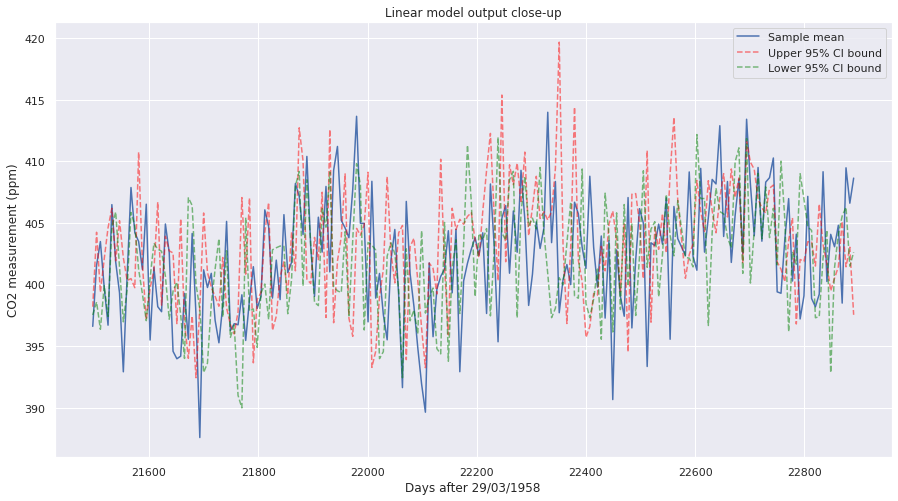

In [39]:
#we will now visualize a close-up of our model outout for the last 200 measurements in the dataset 
plt.figure(figsize=(15,8))
plt.plot(time[3000:3199],linear_mean_line[3000:3199],label='Sample mean',ls='-')
plt.plot(time[3000:3199],linear_upper_line[3000:3199],color='red',label='Upper 95% CI bound',linestyle='dashed',alpha=0.5)
plt.plot(time[3000:3199],linear_lower_line[3000:3199],color='green',label='Lower 95% CI bound',linestyle='dashed',alpha=0.5)
plt.title('Linear model output close-up')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

### Visualizing output of the model against the observed data

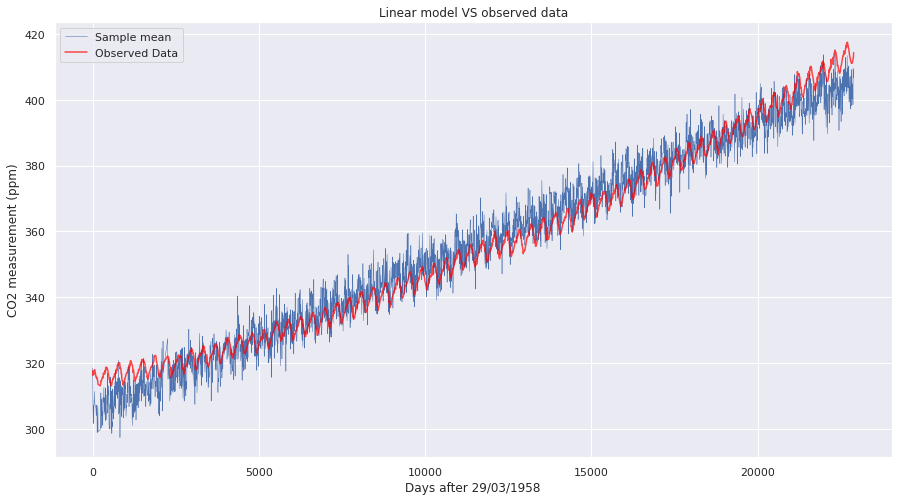

In [40]:
co2=df['CO2']
plt.figure(figsize=(15,8))
plt.plot(time,linear_mean_line,label='Sample mean',linewidth=0.5)
#plt.plot(time,linear_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,linear_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time,co2,label='Observed Data',alpha=0.7,color='red')
plt.title('Linear model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

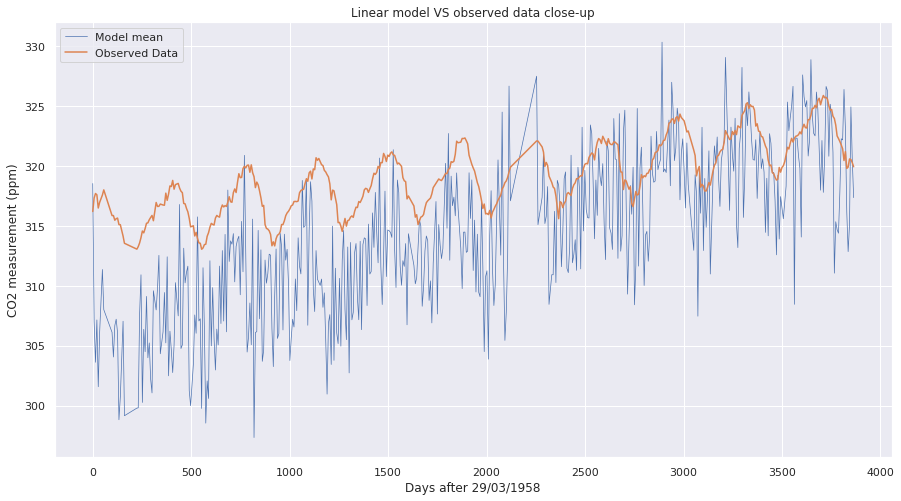

In [41]:
#close up for the first 500 measurements 
plt.figure(figsize=(15,8))
plt.plot(time[0:500],linear_mean_line[0:500],label='Model mean',linewidth=0.7)
#plt.plot(time[0:500],linear_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5)
#plt.plot(time[0:500],linear_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[0:500],co2[0:500],label='Observed Data')
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

We will now visualize a close up of the first and last 200 measurements. 

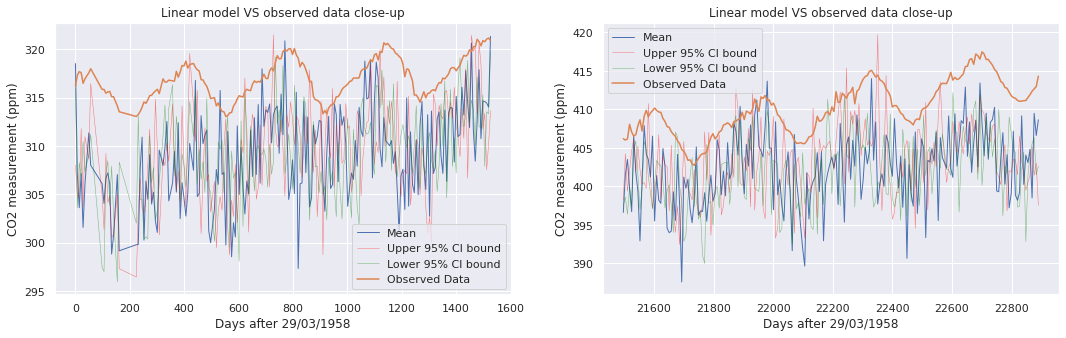

In [42]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(time[0:200],linear_mean_line[0:200],label='Mean',linewidth=1)
plt.plot(time[0:200],linear_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5,alpha=0.5)
plt.plot(time[0:200],linear_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5,alpha=0.5)
plt.plot(time[0:200],co2[0:200],label='Observed Data')
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[3000:3199],linear_mean_line[3000:3199],label='Mean',linewidth=1)
plt.plot(time[3000:3199],linear_upper_line[3000:3199],color='red',label='Upper 95% CI bound',linewidth=0.5,alpha=0.5)
plt.plot(time[3000:3199],linear_lower_line[3000:3199],color='green',label='Lower 95% CI bound',linewidth=0.5,alpha=0.5)
plt.plot(time[3000:3199],co2[3000:3199],label='Observed Data')
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

### A model with a quadratic term

The improvement I want to propose on the suggested model is the addition of a quadratic term in the overall trend. I agree with the way seasonality has been modeled in the suggested model, and with the distribution from which the noise is coming from. I have modified the prior for the $c_2$ parameter to be broader with a scale of 5 instead of 1. This way, I propose the following model: 

* Long term trend has an extra quadratic term: $c_0+c_1t+c_5t^2$
* Seasonal variation (every $365.25$ days): $c_2 cos(2\pi/365.5+c_3)$
* Noise: coming from a Gamma distribution with mean $0$ and standard deviation $c_4$ 
These components give us the following likelihood function: 
$$p(x_t|\theta)=N(c_0+c_1t+c_5t^2+c_2cos(2\pi/365.5+c_3),c_4^2)$$

### Visualizing the priors

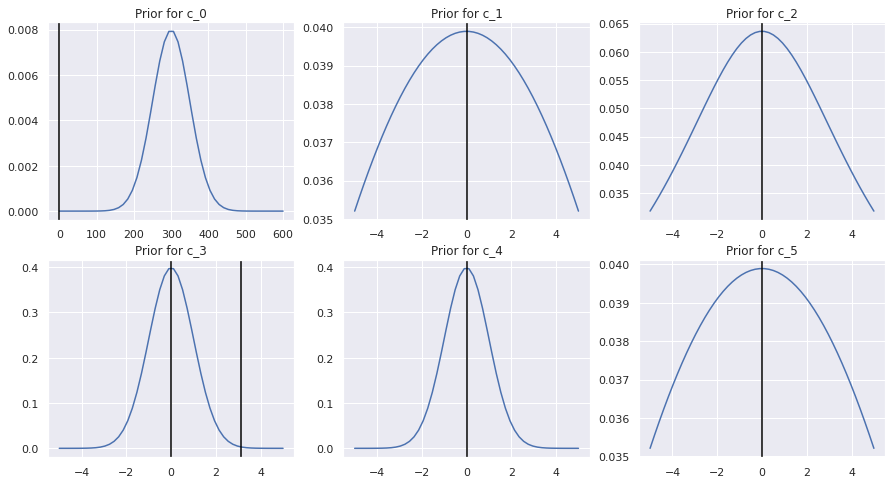

In [43]:
#plotting the priors 
plt.figure(figsize=(15,8))
prior_c0=sts.norm.pdf(np.linspace(0,600),300,50)
prior_c1=sts.norm.pdf(np.linspace(-5,5),0,10)
prior_c2=sts.cauchy.pdf(np.linspace(-5,5),0,5)
prior_c3=sts.norm.pdf(np.linspace(-5,5),0,1)
prior_c4=sts.norm.pdf(np.linspace(-5,5),0,1)
prior_c5=sts.norm.pdf(np.linspace(-5,5),0,10)
plt.subplot(2,3,1)
plt.plot(np.linspace(0,600),prior_c0)
plt.axvline(x=0,color='black')
plt.title('Prior for c_0')
plt.subplot(2,3,2)
plt.plot(np.linspace(-5,5),prior_c1)
plt.axvline(x=0,color='black')
plt.title('Prior for c_1')
plt.subplot(2,3,3)
plt.plot(np.linspace(-5,5),prior_c2)
plt.axvline(x=0,color='black')
plt.title('Prior for c_2')
plt.subplot(2,3,4)
plt.plot(np.linspace(-5,5),prior_c3)
plt.axvline(x=0,color='black')
plt.axvline(x=np.pi,color='black')
plt.title('Prior for c_3')
plt.subplot(2,3,5)
plt.plot(np.linspace(-5,5),prior_c4)
plt.axvline(x=0,color='black')
plt.title('Prior for c_4')
plt.subplot(2,3,6)
plt.plot(np.linspace(-5,5),prior_c5)
plt.axvline(x=0,color='black')
plt.title('Prior for c_5')
plt.show()

### Setting up the new model in STAN 

In [44]:
stan_code_new= """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.

data {  

  int<lower=0> n; //number of observations 
  real<lower=0> co2[n]; // this establishes an n-sized array containing real values named co2 for the CO2 weekly measurements  
  int<lower=0> t[n]; // an array of length n containing ints for the number of days after the first measurement
  //t is our time variable as stated in the assignment description 

}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

  //Overall trend parameters
  real<lower=0> c_0; //y-intercept
  real<lower=0> c_1; //linear term 
  real<lower=0> c_5; //quadratic term 

  //Seasonal variation parameters 
  real<lower=0> c_2; //amplitude 
  real<lower=0,upper=pi()> c_3; //horizontal (phase) shift 


  //Noise parameters 
  real<lower=0> c_4; //standard deviation for Gaussian which provides us with the noise 
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.
model {
    //priors
    c_0~normal(300,50); //prior for y-intercept 
    c_1~normal(0,10); //prior for linear term (somewhat broad normal)
    c_5~normal(0,10);//prior for the quadratic term, same prior as the one for the linear term
    c_2~cauchy(0,1); //prior for the amplitude (cauchy because I want to have enough density at the tails)
    c_3~normal(0,1);//prior for the phase shift 
    c_4~normal(0,1); //prior for the stdev for the noise coming from the Gaussian centered at 0 

    //likelihood 
    for (i in 1:n){
      co2[i]~normal(c_0+c_1*t[i]+c_5*(t[i]^2)+c_2*cos((2*pi()*t[i]/365.25)+c_3),c_4);
    }
}
"""

In [45]:
stan_model_new=pystan.StanModel(model_code=stan_code_new)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c2ad6e075a9782722346366cbd5d54a NOW.


In [46]:
data

{'co2': array([316.19, 317.31, 317.69, ..., 412.67, 412.98, 414.32]),
 'n': 3199,
 't': array([    0,     7,    14, ..., 22876, 22883, 22890])}

### STAN output of the new model 

In [47]:
stan_new_results=stan_model_new.sampling(data=data,seed=12213)
print(stan_new_results)

Inference for Stan model: anon_model_5c2ad6e075a9782722346366cbd5d54a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean      sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
c_0  314.66  1.9e-3    0.07 314.52 314.61 314.66  314.7  314.79   1300    1.0
c_1  2.1e-3  4.3e-7  1.4e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3  2.1e-3   1010    1.0
c_5  9.9e-8 1.8e-11 5.7e-10 9.7e-8 9.8e-8 9.9e-8 9.9e-8 10.0e-8   1021    1.0
c_2    2.62  5.7e-4    0.03   2.56    2.6   2.62   2.64    2.68   3337    1.0
c_3  3.5e-4  6.8e-6  3.4e-4 1.0e-5 1.1e-4 2.5e-4 4.9e-4  1.3e-3   2514    1.0
c_4    1.29  2.8e-4    0.02   1.26   1.28   1.29    1.3    1.32   3232    1.0
lp__  -2433    0.05    1.73  -2437  -2434  -2432  -2431   -2430   1290    1.0

Samples were drawn using NUTS at Wed Dec 16 05:50:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on spli

In [48]:
samples_new=stan_new_results.extract()

In [49]:
new_params=['c_0','c_1','c_2','c_3','c_4','c_5']

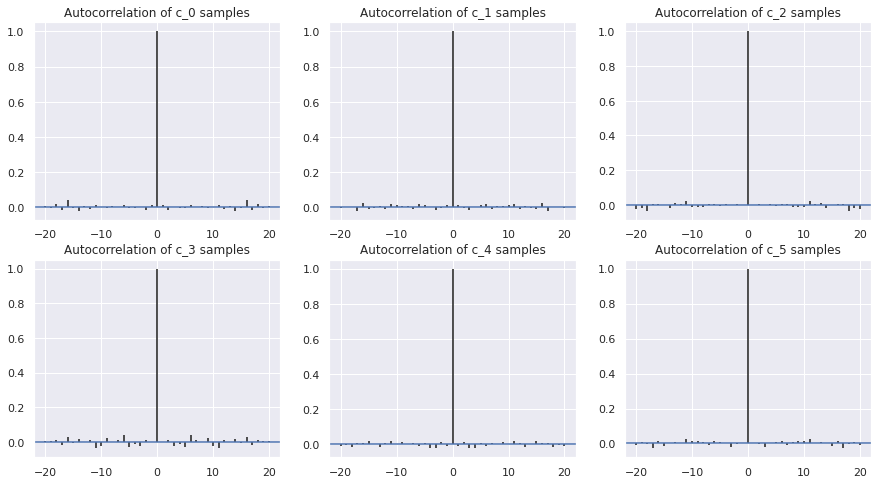

In [50]:
#plotting the autocorrelations 
plt.figure(figsize=(15,8))
plt.subplot(2,3,1)
plot_acf(samples_new['c_0'])
plt.title('Autocorrelation of c_0 samples')
plt.subplot(2,3,2)
plot_acf(samples_new['c_1'])
plt.title('Autocorrelation of c_1 samples')
plt.subplot(2,3,3)
plot_acf(samples_new['c_2'])
plt.title('Autocorrelation of c_2 samples')
plt.subplot(2,3,4)
plot_acf(samples_linear['c_3'])
plt.title('Autocorrelation of c_3 samples')
plt.subplot(2,3,5)
plot_acf(samples_new['c_4'])
plt.title('Autocorrelation of c_4 samples')
plt.subplot(2,3,6)
plot_acf(samples_new['c_5'])
plt.title('Autocorrelation of c_5 samples')
plt.show()

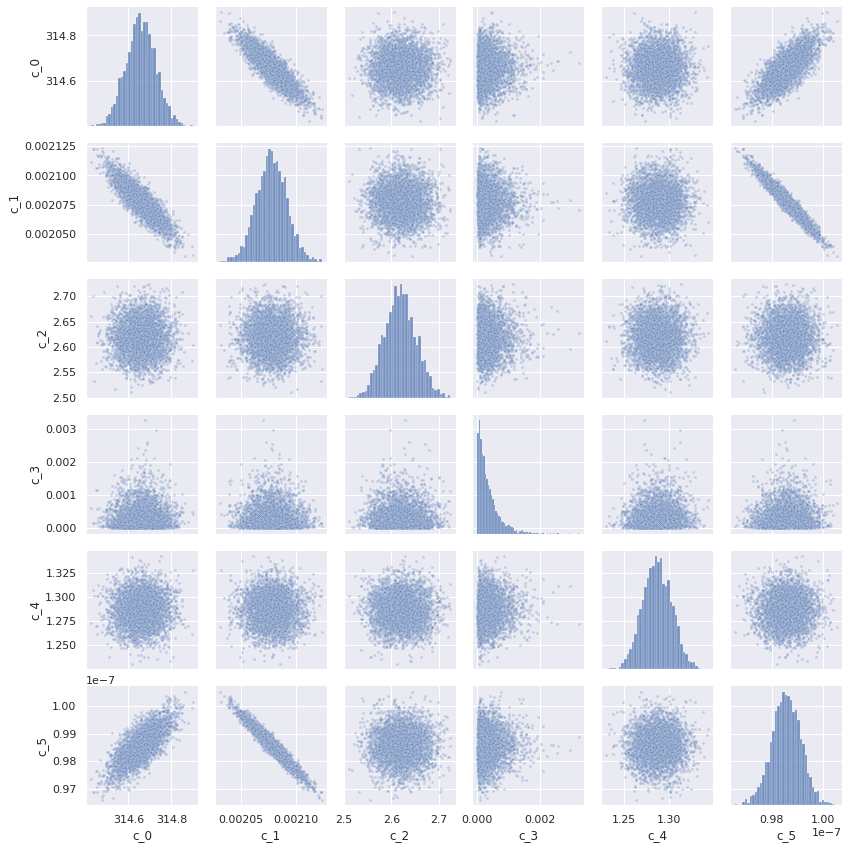

In [51]:
pairplot(samples_new,new_params,2)

### STAN output visualization 

In [52]:
new_means=[np.mean(samples_new[param]) for param in new_params]
new_upper=[np.percentile(samples_new[param],97.5) for param in new_params]
new_lower=[np.percentile(samples_new[param],2.5) for param in new_params]
new_means=np.asarray(new_means)
new_upper=np.asarray(new_upper)
new_lower=np.asarray(new_lower)
print('new means:',new_means)
print('new lower bound:',new_lower)
print('new upper bound:',new_upper)
for i in range(6):
  print(f'Parameter:{new_params[i]} mean:{new_means[i]}, lower:{new_lower[i]},upper:{new_upper[i]}')

new means: [3.14657909e+02 2.07782022e-03 2.61894625e+00 3.51706836e-04
 1.28672135e+00 9.85752751e-08]
new lower bound: [3.14522744e+02 2.05093447e-03 2.55631376e+00 1.01409141e-05
 1.25578806e+00 9.74275212e-08]
new upper bound: [3.14793682e+02 2.10529801e-03 2.68410172e+00 1.25063564e-03
 1.31807426e+00 9.96925606e-08]
Parameter:c_0 mean:314.6579090842502, lower:314.5227438142256,upper:314.793681945897
Parameter:c_1 mean:0.00207782022201992, lower:0.002050934471352606,upper:0.0021052980069225947
Parameter:c_2 mean:2.6189462463656348, lower:2.55631375972951,upper:2.684101716967475
Parameter:c_3 mean:0.00035170683562496107, lower:1.0140914068275199e-05,upper:0.0012506356388991228
Parameter:c_4 mean:1.286721346319537, lower:1.2557880642096504,upper:1.3180742588569416
Parameter:c_5 mean:9.857527505876238e-08, lower:9.742752123606972e-08,upper:9.969256060361992e-08


In [53]:
#c_0 is c[0]
#c_1 is c[1]
#c_2 is c[2]
#c_3 is c[3]
#c_4 is c[4]

#function is normal(c_0+c_1*t[i]+c_5*t^2+c_2*cos((2*pi()*t[i]/365.25)+c_3),c_4)

def new_outputs(t,c):
  return np.array(sts.norm.rvs(c[0]+c[1]*t+c[5]*(t**2)+c[2]*np.cos((2*np.pi*t/365.25)+c[3]),c[4]))

In [54]:
new_mean_line=new_outputs(time,new_means)
new_upper_line=new_outputs(time,new_upper)
new_lower_line=new_outputs(time,new_lower)

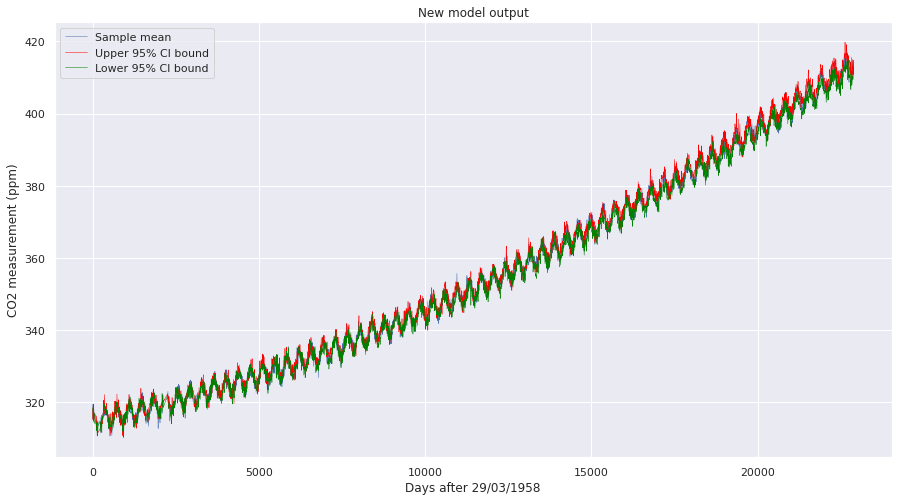

In [55]:
plt.figure(figsize=(15,8))
plt.plot(time,new_mean_line,label='Sample mean',linewidth=0.5)
plt.plot(time,new_upper_line,color='red',label='Upper 95% CI bound',linewidth=0.5)
plt.plot(time,new_lower_line,color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.title('New model output')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

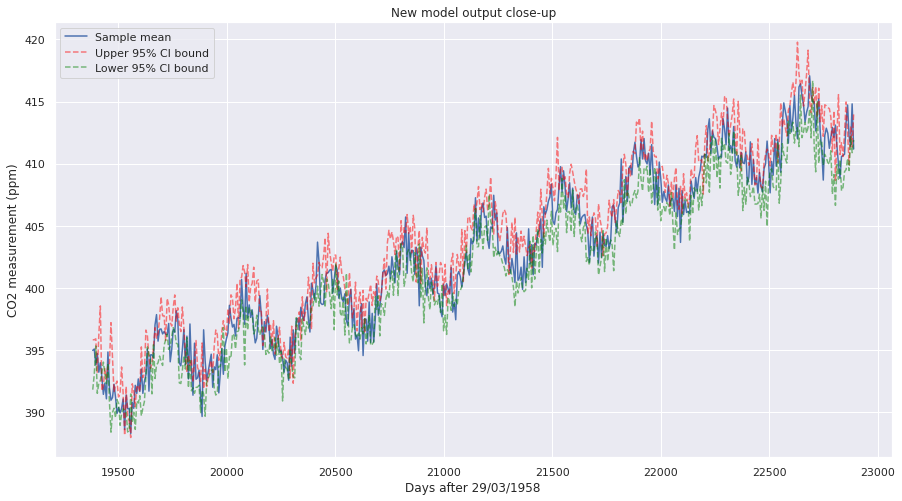

In [56]:
#close-up for the last 500 measurements 
plt.figure(figsize=(15,8))
plt.plot(time[2700:3199],new_mean_line[2700:3199],label='Sample mean',ls='-')
plt.plot(time[2700:3199],new_upper_line[2700:3199],color='red',label='Upper 95% CI bound',linestyle='dashed',alpha=0.5)
plt.plot(time[2700:3199],new_lower_line[2700:3199],color='green',label='Lower 95% CI bound',linestyle='dashed',alpha=0.5)
plt.title('New model output close-up')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

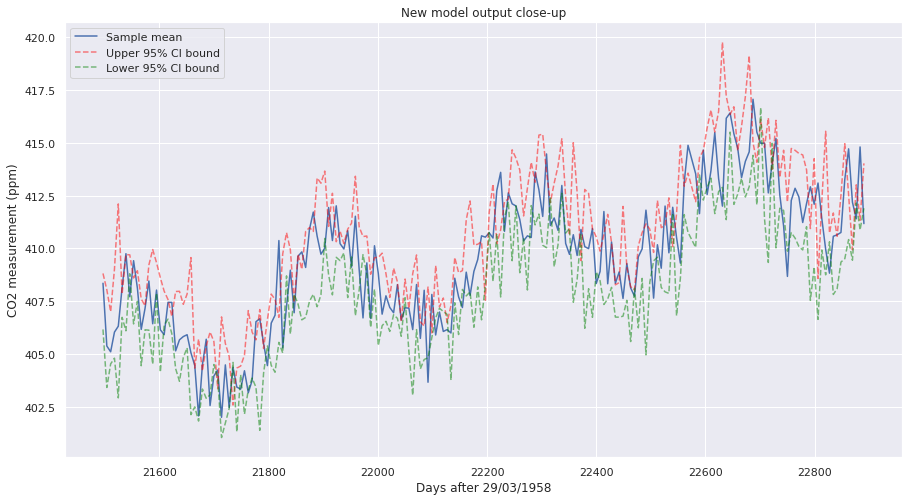

In [57]:
#we will now visualize a close-up of our model outout for the last 100 measurements in the dataset 
plt.figure(figsize=(15,8))
plt.plot(time[3000:3199],new_mean_line[3000:3199],label='Sample mean',ls='-')
plt.plot(time[3000:3199],new_upper_line[3000:3199],color='red',label='Upper 95% CI bound',linestyle='dashed',alpha=0.5)
plt.plot(time[3000:3199],new_lower_line[3000:3199],color='green',label='Lower 95% CI bound',linestyle='dashed',alpha=0.5)
plt.title('New model output close-up')
plt.legend()
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.show()

### Visualizing output of the model against the observed data

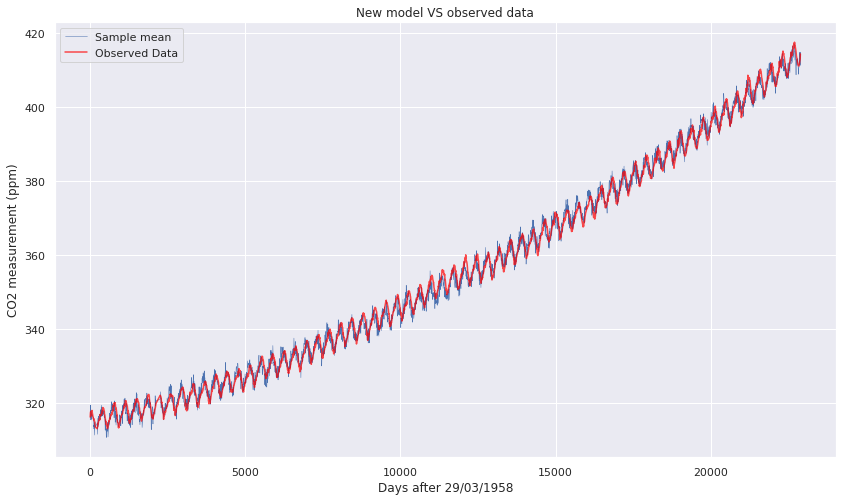

In [58]:
co2=df['CO2']
plt.figure(figsize=(14,8))
plt.plot(time,new_mean_line,label='Sample mean',linewidth=0.5)
#plt.plot(time,new_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,new_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time,co2,label='Observed Data',alpha=0.7,color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

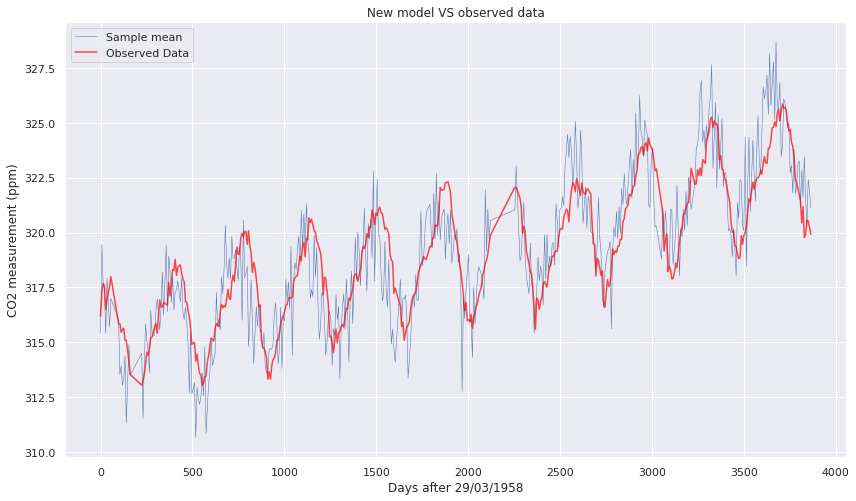

In [59]:
#close-up of the first 500 measurements 
co2=df['CO2']
plt.figure(figsize=(14,8))
plt.plot(time[0:500],new_mean_line[0:500],label='Sample mean',linewidth=0.5)
#plt.plot(time,new_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,new_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time[0:500],co2[0:500],label='Observed Data',alpha=0.7,color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

Visualizing the new model output for the first and last 200 measurements

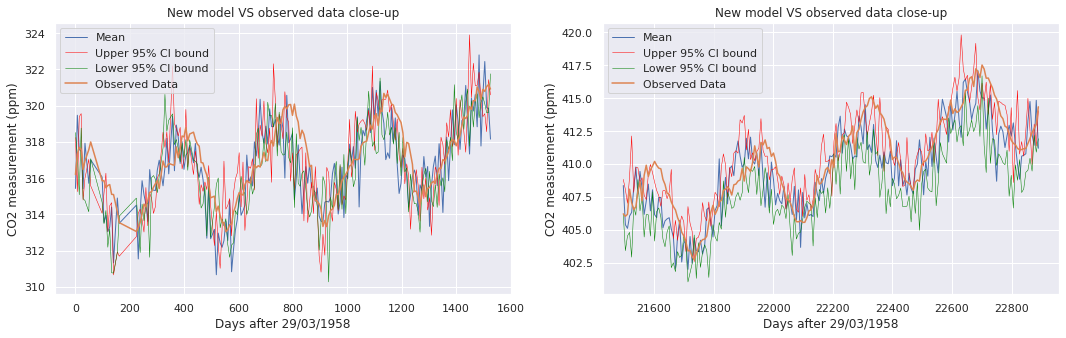

In [60]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(time[0:200],new_mean_line[0:200],label='Mean',linewidth=1)
plt.plot(time[0:200],new_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5)
plt.plot(time[0:200],new_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[0:200],co2[0:200],label='Observed Data')
plt.title('New model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[3000:3199],new_mean_line[3000:3199],label='Mean',linewidth=1)
plt.plot(time[3000:3199],new_upper_line[3000:3199],color='red',label='Upper 95% CI bound',linewidth=0.5)
plt.plot(time[3000:3199],new_lower_line[3000:3199],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[3000:3199],co2[3000:3199],label='Observed Data')
plt.title('New model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

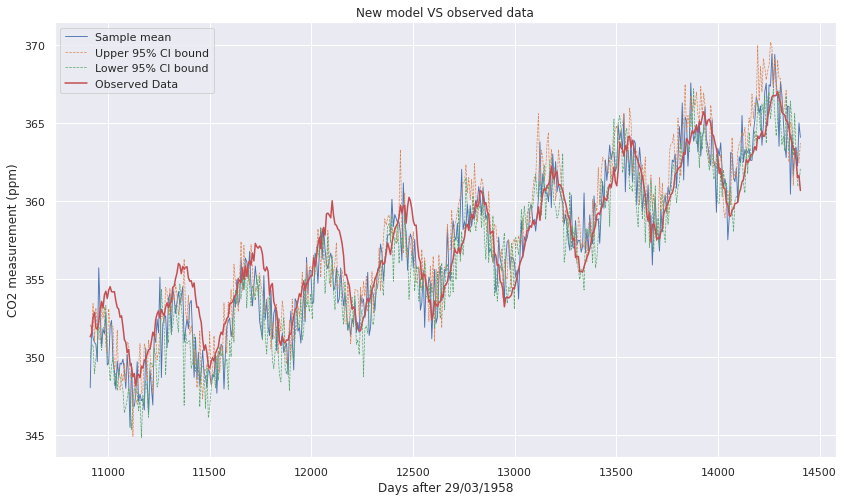

In [61]:
#additional close-ups 
co2=df['CO2']
plt.figure(figsize=(14,8))
plt.plot(time[1500:2000],new_mean_line[1500:2000],label='Sample mean',linewidth=0.9)
plt.plot(time[1500:2000],new_upper_line[1500:2000],label='Upper 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[1500:2000],new_lower_line[1500:2000],label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[1500:2000],co2[1500:2000],label='Observed Data')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

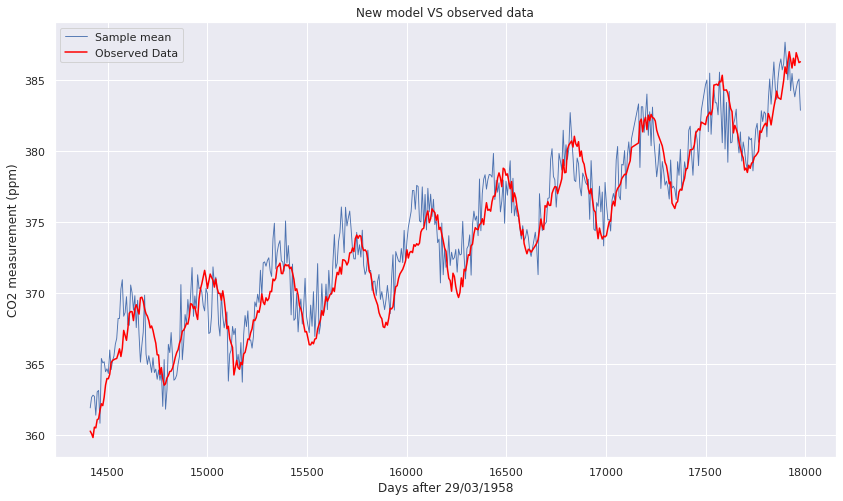

In [62]:
#additional close-ups 
co2=df['CO2']
plt.figure(figsize=(14,8))
plt.plot(time[2000:2500],new_mean_line[2000:2500],label='Sample mean',linewidth=0.9)
#plt.plot(time[1500:2000],new_upper_line[1500:2000],label='Upper 95% CI bound',linewidth=0.7,linestyle='dashed')
#plt.plot(time[1500:2000],new_lower_line[1500:2000],label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[2000:2500],co2[2000:2500],label='Observed Data',color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

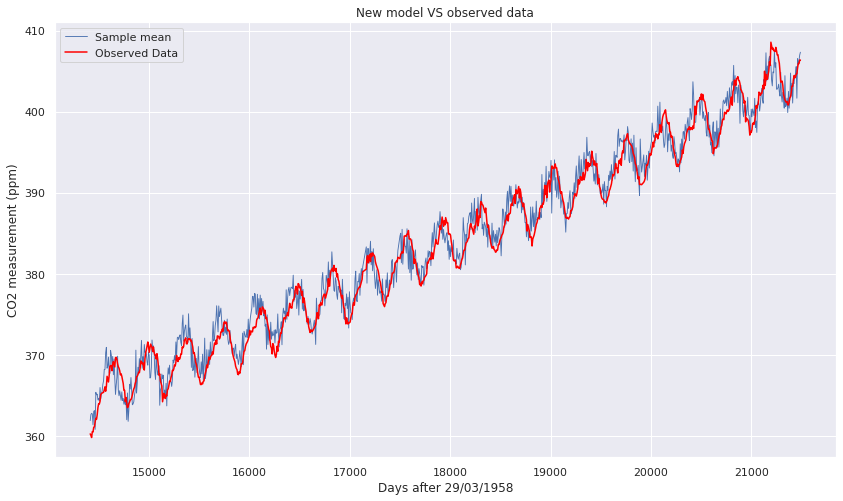

In [63]:
#additional close-ups 
co2=df['CO2']
plt.figure(figsize=(14,8))
plt.plot(time[2000:3000],new_mean_line[2000:3000],label='Sample mean',linewidth=0.9)
plt.plot(time[2000:3000],co2[2000:3000],label='Observed Data',color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

### Comparing the linear model with the new model 


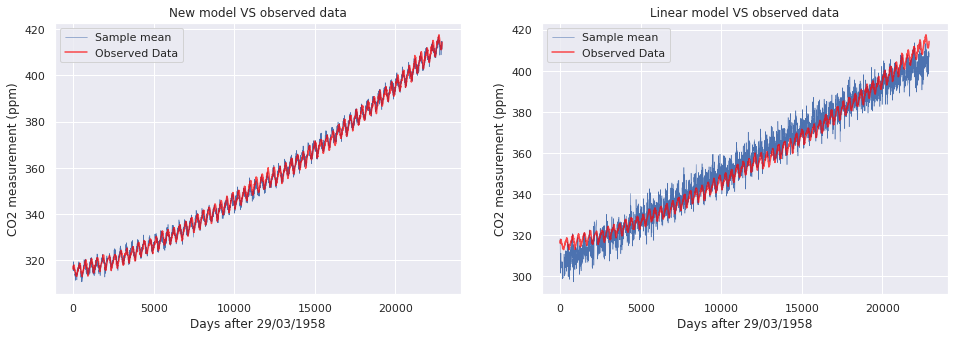

In [64]:
co2=df['CO2']
#comparing model output against observed data for the whole dataset 
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(time,new_mean_line,label='Sample mean',linewidth=0.5)
#plt.plot(time,new_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,new_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time,co2,label='Observed Data',alpha=0.7,color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time,linear_mean_line,label='Sample mean',linewidth=0.5)
#plt.plot(time,linear_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,linear_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time,co2,label='Observed Data',alpha=0.7,color='red')
plt.title('Linear model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

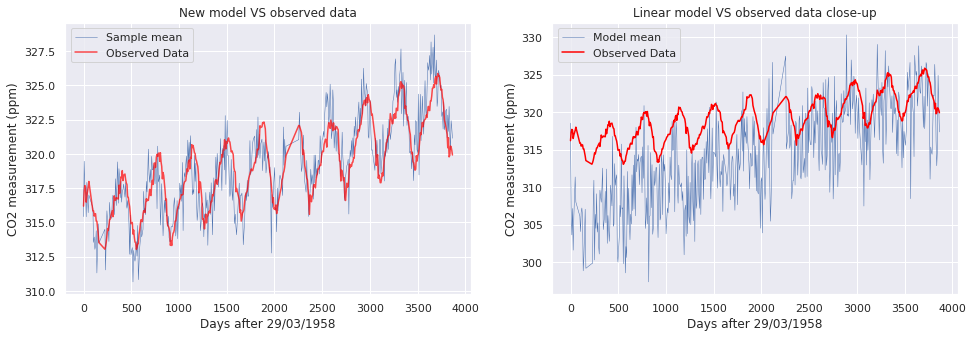

In [65]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(time[0:500],new_mean_line[0:500],label='Sample mean',linewidth=0.5)
#plt.plot(time,new_upper_line,color='red',label='Upper 95% CI bound')
#plt.plot(time,new_lower_line,color='green',label='Lower 95% CI bound')
plt.plot(time[0:500],co2[0:500],label='Observed Data',alpha=0.7,color='red')
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[0:500],linear_mean_line[0:500],label='Model mean',linewidth=0.5)
#plt.plot(time[0:500],linear_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5)
#plt.plot(time[0:500],linear_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[0:500],co2[0:500],label='Observed Data',color='red')
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

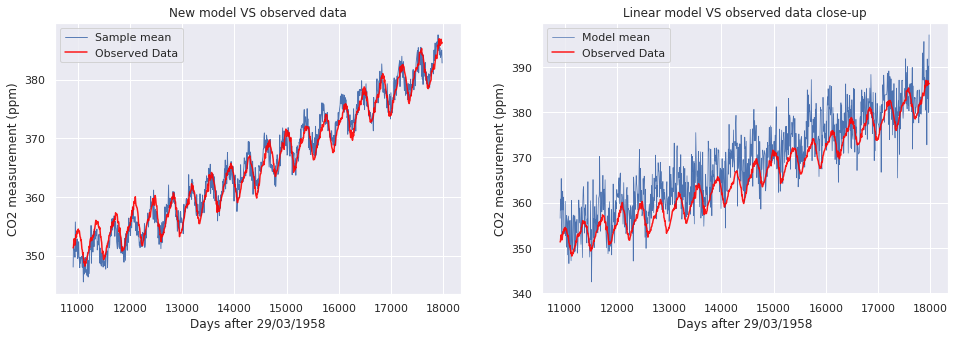

In [66]:
#additional close-ups 
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(time[1500:2500],new_mean_line[1500:2500],label='Sample mean',linewidth=0.9)
#plt.plot(time[1500:2000],new_upper_line[1500:2000],label='Upper 95% CI bound',linewidth=0.7,linestyle='dashed')
#plt.plot(time[1500:2000],new_lower_line[1500:2000],label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[1500:2500],co2[1500:2500],label='Observed Data',color='red',alpha=0.9)
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[1500:2500],linear_mean_line[1500:2500],label='Model mean',linewidth=0.7)
#plt.plot(time[0:500],linear_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5)
#plt.plot(time[0:500],linear_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[1500:2500],co2[1500:2500],label='Observed Data',color='red',alpha=0.9)
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

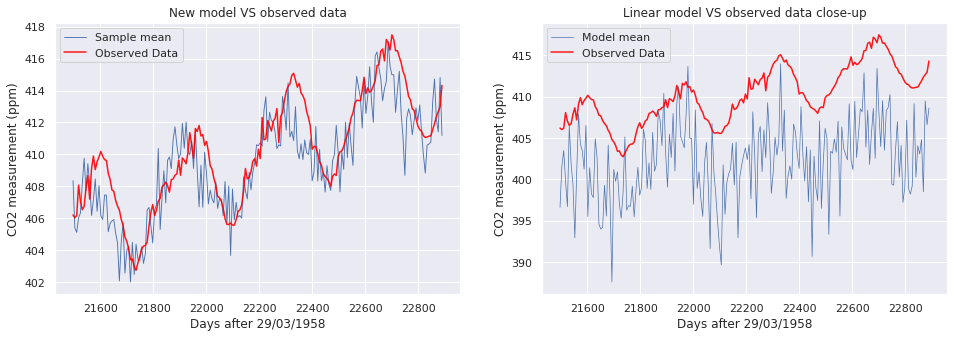

In [67]:
#additional close-ups 
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(time[3000:3199],new_mean_line[3000:3199],label='Sample mean',linewidth=0.9)
#plt.plot(time[1500:2000],new_upper_line[1500:2000],label='Upper 95% CI bound',linewidth=0.7,linestyle='dashed')
#plt.plot(time[1500:2000],new_lower_line[1500:2000],label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[3000:3199],co2[3000:3199],label='Observed Data',color='red',alpha=0.9)
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[3000:3199],linear_mean_line[3000:3199],label='Model mean',linewidth=0.7)
#plt.plot(time[0:500],linear_upper_line[0:200],color='red',label='Upper 95% CI bound',linewidth=0.5)
#plt.plot(time[0:500],linear_lower_line[0:200],color='green',label='Lower 95% CI bound',linewidth=0.5)
plt.plot(time[3000:3199],co2[3000:3199],label='Observed Data',color='red',alpha=0.9)
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

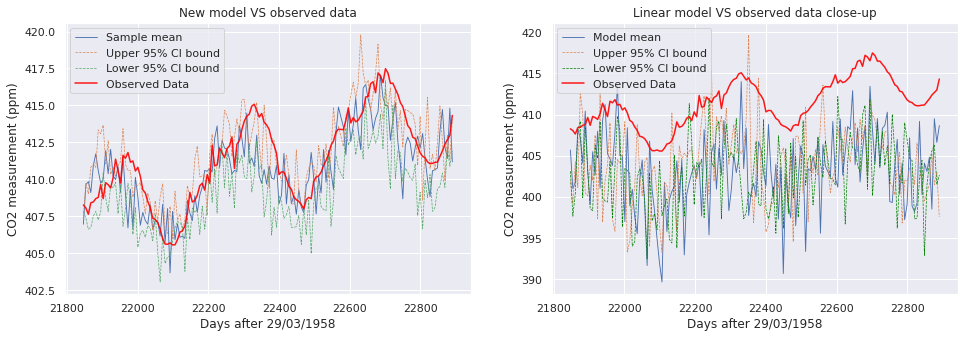

In [68]:
#additional close-ups 
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(time[3050:3199],new_mean_line[3050:3199],label='Sample mean',linewidth=0.9)
plt.plot(time[3050:3199],new_upper_line[3050:3199],label='Upper 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[3050:3199],new_lower_line[3050:3199],label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[3050:3199],co2[3050:3199],label='Observed Data',color='red',alpha=0.9)
plt.title('New model VS observed data')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time[3050:3199],linear_mean_line[3050:3199],label='Model mean',linewidth=0.9)
plt.plot(time[3050:3199],linear_upper_line[3050:3199],label='Upper 95% CI bound',linestyle='dashed',linewidth=0.7)
plt.plot(time[3050:3199],linear_lower_line[3050:3199],color='green',label='Lower 95% CI bound',linewidth=0.7,linestyle='dashed')
plt.plot(time[3050:3199],co2[3050:3199],label='Observed Data',color='red',alpha=0.9)
plt.title('Linear model VS observed data close-up')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

### Replicated datasets and RMSE comparison

I will generated replicated datasets using all 4000 samples from both models. Then I will compared the root mean squared error between the model samples and the observed data, for both models.

In [69]:
samples_linear

OrderedDict([('c_0',
              array([305.6837211 , 305.83876551, 305.85834923, ..., 305.65864642,
                     305.42664563, 305.64370603])),
             ('c_1',
              array([0.00435486, 0.00434844, 0.0043499 , ..., 0.00436351, 0.00437983,
                     0.0043528 ])),
             ('c_2',
              array([2.49326721, 2.48377828, 2.42076051, ..., 2.41395037, 2.41101994,
                     2.49528219])),
             ('c_3',
              array([0.00574419, 0.0026258 , 0.00322897, ..., 0.00376314, 0.00162708,
                     0.00099579])),
             ('c_4',
              array([4.02125143, 4.0450023 , 4.07220101, ..., 3.99156023, 3.93168341,
                     4.13479761])),
             ('lp__',
              array([-6065.09559881, -6065.40455227, -6066.97576873, ...,
                     -6066.21825705, -6070.00270799, -6069.22415892]))])

In [72]:
#creating replicated datasets 
#np.array(sts.norm.rvs(c[0]+c[1]*t+c[2]*np.cos((2*np.pi*t/365.25)+c[3]),c[4]))
def create_rep_linear(samples,t):
  lin_rep=np.zeros((4000,len(time)))
  for i in range(4000):
    lin_rep[i,:]=sts.norm.rvs(samples['c_0'][i]+samples['c_1'][i]*t+samples['c_2'][i]*np.cos((2*np.pi*t/365.25)+samples['c_3'][i]),samples['c_4'][i])
  return lin_rep 
def create_rep_new(samples,t):
  new_rep=np.zeros((4000,len(time)))
  for i in range(4000):
     new_rep[i,:]=sts.norm.rvs(samples['c_0'][i]+samples['c_1'][i]*t+samples['c_5'][i]*(t**2)+samples['c_2'][i]*np.cos((2*np.pi*t/365.25)+samples['c_3'][i]),samples['c_4'][i])
  return new_rep 

In [77]:
#replicated datasets 
lin_rep=create_rep_linear(samples_linear,time)
new_rep=create_rep_new(samples_new,time)
#len(new_rep)

In [78]:
def RMSE(rep):
  rmse=[]
  for i in range(len(rep)):
    rmse.append(np.mean(np.sqrt((co2-rep[i,:])**2)))
  return rmse

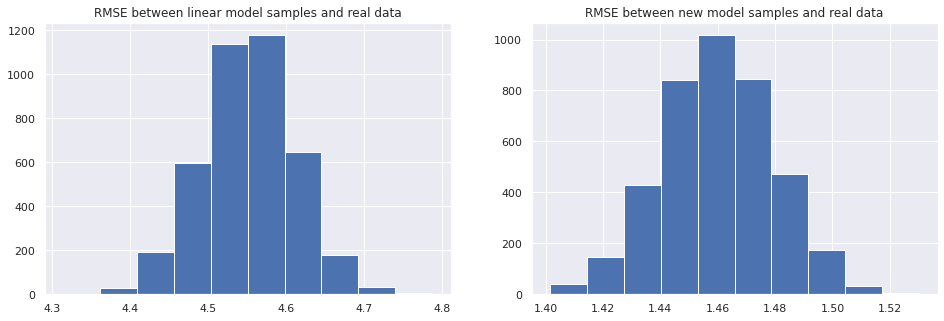

In [80]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(RMSE(lin_rep))
plt.title('RMSE between linear model samples and real data')
plt.subplot(1,2,2)
plt.hist(RMSE(new_rep))
plt.title('RMSE between new model samples and real data')
plt.show()

### Mean, variance, and max-min values

In this section I will compare the mean, variance, and minimum and maximum between my replicated datasets and the actual data. The mean and variance are informative test statistics, but the minimum and maximum values will tell us about the range of $CO_2$ predictions our models are generating, compared to the observed data.

In [138]:
new_rep

array([[316.80406665, 317.32141248, 318.29623283, ..., 412.65620632,
        411.49793877, 410.14010386],
       [318.72953267, 316.41558422, 316.61213777, ..., 411.22657718,
        413.12478542, 410.75674012],
       [316.93231242, 318.3667265 , 316.64895866, ..., 411.07907345,
        412.02277947, 412.44333311],
       ...,
       [315.1721895 , 319.28764178, 318.67843128, ..., 411.61645858,
        411.68262479, 410.25429897],
       [318.04636158, 313.85716556, 318.61906265, ..., 413.63978643,
        413.24275759, 411.80728282],
       [317.22092456, 319.7396429 , 317.63639046, ..., 411.28851745,
        413.0036334 , 410.83221058]])

In [146]:
np.mean(co2)

356.17227883713724

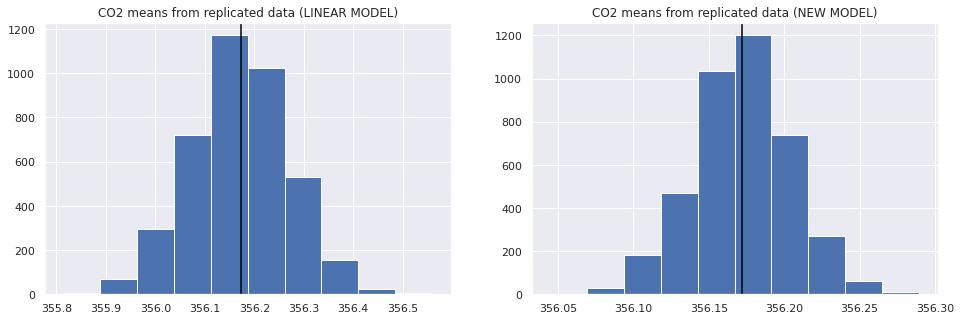

In [151]:
#mean
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist([np.mean(i) for i in lin_rep])
plt.axvline(x=np.mean(co2),color='black')
plt.title('CO2 means from replicated data (LINEAR MODEL)')
plt.subplot(1,2,2)
plt.hist([np.mean(i) for i in new_rep])
plt.axvline(x=np.mean(co2),color='black')
plt.title('CO2 means from replicated data (NEW MODEL)')
plt.show()

In [153]:
np.var(co2)

831.302356263605

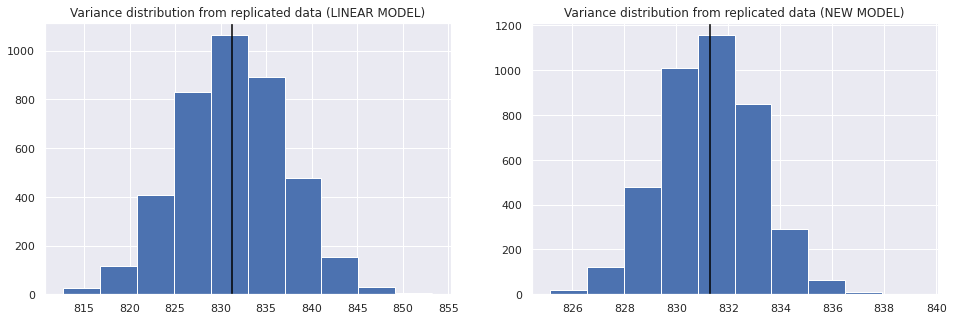

In [152]:
#variance
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist([np.var(i) for i in lin_rep])
plt.axvline(x=np.var(co2),color='black')
plt.title('Variance distribution from replicated data (LINEAR MODEL)')
plt.subplot(1,2,2)
plt.hist([np.var(i) for i in new_rep])
plt.axvline(x=np.var(co2),color='black')
plt.title('Variance distribution from replicated data (NEW MODEL)')
plt.show()

In [154]:
np.max(co2)

417.49

In [155]:
np.min(co2)

313.04

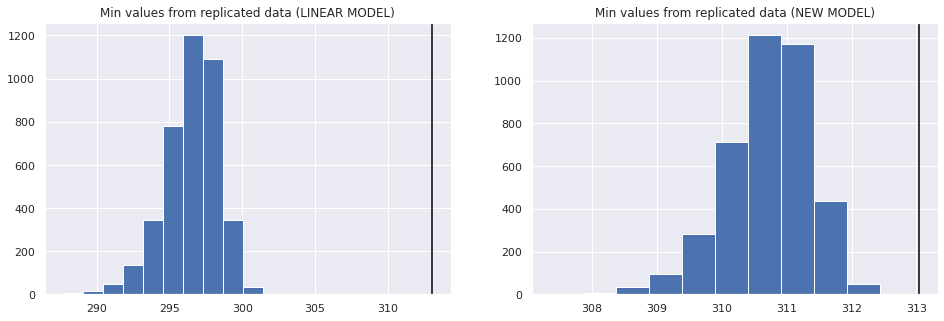

In [156]:
#min value
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist([np.min(i) for i in lin_rep])
plt.axvline(x=np.min(co2),color='black')
plt.title('Min values from replicated data (LINEAR MODEL)')
plt.subplot(1,2,2)
plt.hist([np.min(i) for i in new_rep])
plt.axvline(x=np.min(co2),color='black')
plt.title('Min values from replicated data (NEW MODEL)')
plt.show()

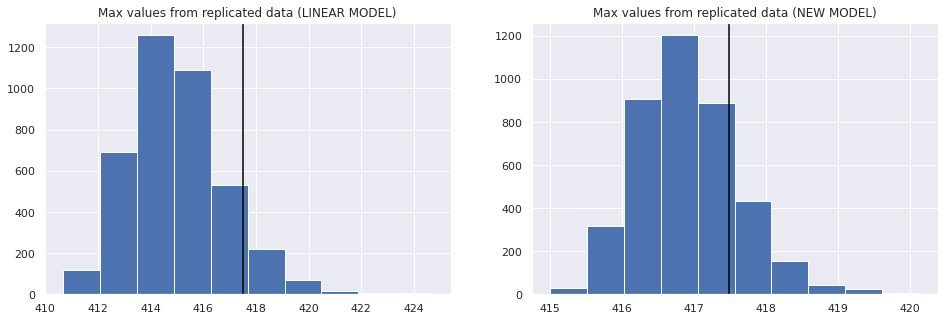

In [157]:
#max value 
#mean
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist([np.max(i) for i in lin_rep])
plt.axvline(x=np.max(co2),color='black')
plt.title('Max values from replicated data (LINEAR MODEL)')
plt.subplot(1,2,2)
plt.hist([np.max(i) for i in new_rep])
plt.axvline(x=np.max(co2),color='black')
plt.title('Max values from replicated data (NEW MODEL)')
plt.show()

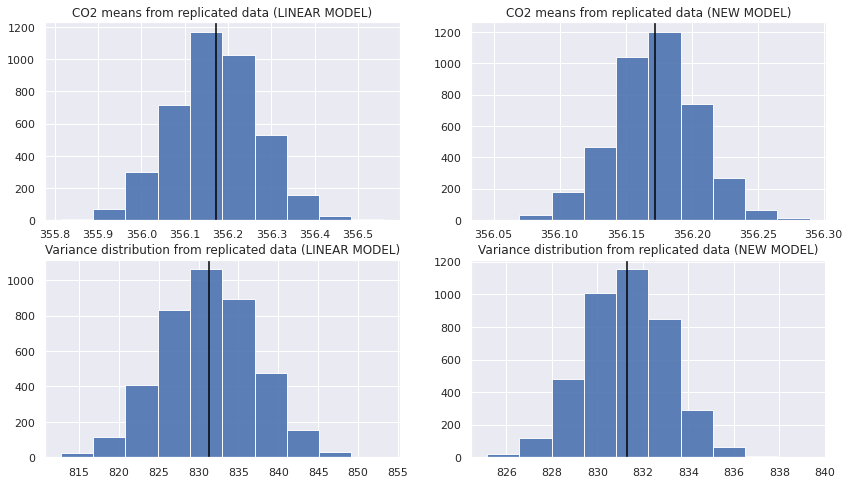

In [170]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.hist([np.mean(i) for i in lin_rep],alpha=0.9)
plt.axvline(x=np.mean(co2),color='black')
plt.title('CO2 means from replicated data (LINEAR MODEL)')
plt.subplot(2,2,2)
plt.hist([np.mean(i) for i in new_rep],alpha=0.9)
plt.axvline(x=np.mean(co2),color='black')
plt.title('CO2 means from replicated data (NEW MODEL)')
plt.subplot(2,2,3)
plt.hist([np.var(i) for i in lin_rep],alpha=0.9)
plt.axvline(x=np.var(co2),color='black')
plt.title('Variance distribution from replicated data (LINEAR MODEL)')
plt.subplot(2,2,4)
plt.hist([np.var(i) for i in new_rep],alpha=0.9)
plt.axvline(x=np.var(co2),color='black')
plt.title('Variance distribution from replicated data (NEW MODEL)')
plt.show()

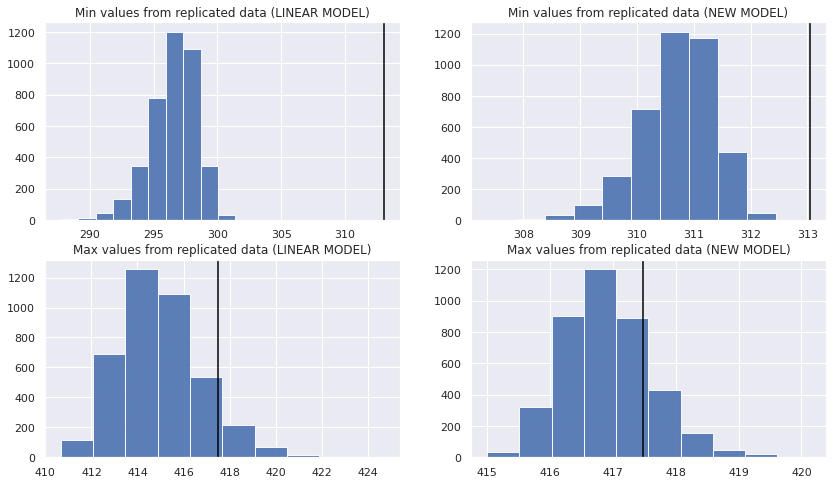

In [171]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.hist([np.min(i) for i in lin_rep],alpha=0.9)
plt.axvline(x=np.min(co2),color='black')
plt.title('Min values from replicated data (LINEAR MODEL)')
plt.subplot(2,2,2)
plt.hist([np.min(i) for i in new_rep],alpha=0.9)
plt.axvline(x=np.min(co2),color='black')
plt.title('Min values from replicated data (NEW MODEL)')
plt.subplot(2,2,3)
plt.hist([np.max(i) for i in lin_rep],alpha=0.9)
plt.axvline(x=np.max(co2),color='black')
plt.title('Max values from replicated data (LINEAR MODEL)')
plt.subplot(2,2,4)
plt.hist([np.max(i) for i in new_rep],alpha=0.9)
plt.axvline(x=np.max(co2),color='black')
plt.title('Max values from replicated data (NEW MODEL)')
plt.show()

### Making predictions using the new model 

In [82]:
time[-1]

22890

In [111]:
14610+22890

37500

In [116]:
new_time=np.array(range(22890,37254, 7)) #making an array for out t variable, to simulate weekly measurements for the next 40 years, I used 
# this https://www.timeanddate.com/date/durationresult.html?d1=29&m1=3&y1=1958&d2=27&m2=3&y2=2060
#to calculate the days until 27/march/2060 which is exactly when the 5322th measurement will be made 
new_time

array([22890, 22897, 22904, ..., 37233, 37240, 37247])

In [117]:
new_means

array([3.14657909e+02, 2.07782022e-03, 2.61894625e+00, 3.51706836e-04,
       1.28672135e+00, 9.85752751e-08])

In [118]:
#remembering the function new_outputs 
#def new_outputs(t,c):
  #return np.array(sts.norm.rvs(c[0]+c[1]*t+c[5]*(t**2)+c[2]*np.cos((2*np.pi*t/365.25)+c[3]),c[4]))
pred_mean=new_outputs(new_time,new_means)
pred_upper=new_outputs(new_time,new_upper)
pred_lower=new_outputs(new_time,new_lower)

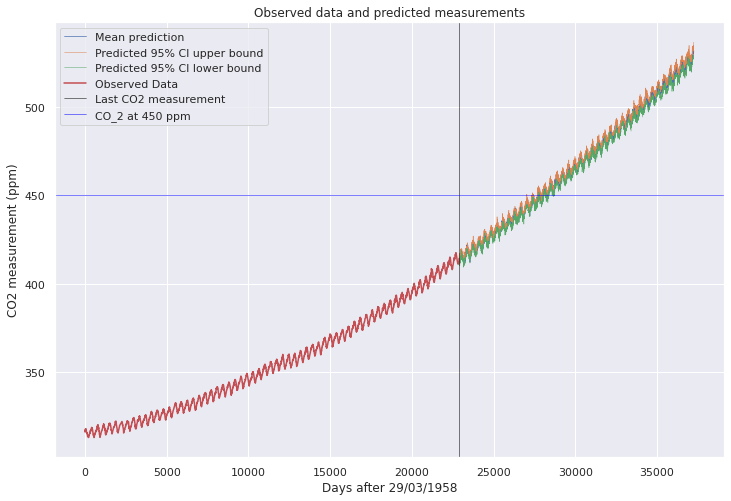

In [123]:
plt.figure(figsize=(12,8))
plt.plot(new_time,pred_mean,label='Mean prediction',linewidth=0.7)
plt.plot(new_time,pred_upper,label='Predicted 95% CI upper bound',linewidth=0.5)
plt.plot(new_time,pred_lower,label='Predicted 95% CI lower bound',linewidth=0.5)
plt.plot(time,co2,label='Observed Data')
plt.axvline(x=new_time[0],color='black',linewidth=0.5,label='Last CO2 measurement')
plt.axhline(y=450,color='blue',label='CO_2 at 450 ppm',linewidth=0.5)
plt.title('Observed data and predicted measurements')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

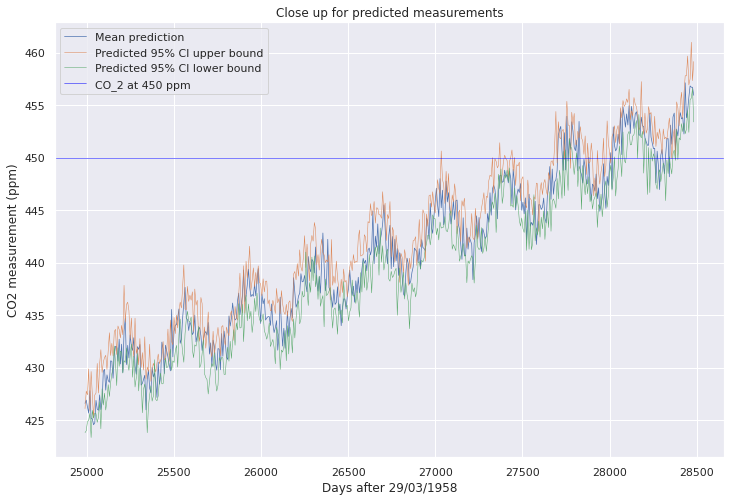

In [137]:
#closeups for the predicted data 
plt.figure(figsize=(12,8))
plt.plot(new_time[300:800],pred_mean[300:800],label='Mean prediction',linewidth=0.7)
plt.plot(new_time[300:800],pred_upper[300:800],label='Predicted 95% CI upper bound',linewidth=0.5)
plt.plot(new_time[300:800],pred_lower[300:800],label='Predicted 95% CI lower bound',linewidth=0.5)
plt.axhline(y=450,color='blue',label='CO_2 at 450 ppm',linewidth=0.5)
plt.title('Close up for predicted measurements')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

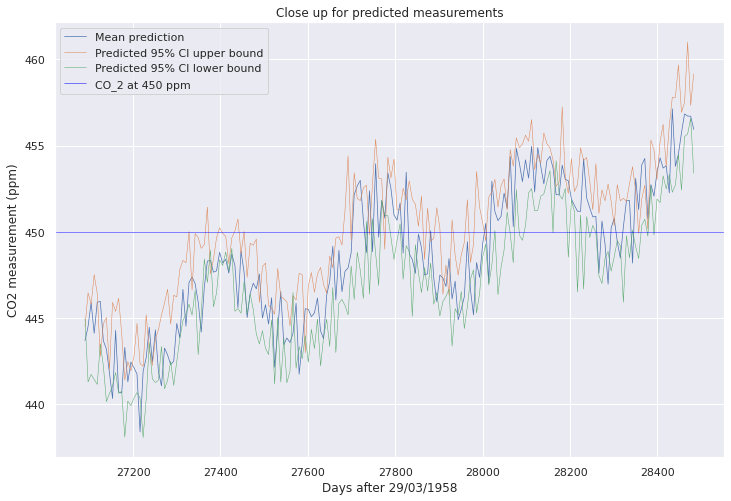

In [132]:
#closeups for the predicted data 
plt.figure(figsize=(12,8))
plt.plot(new_time[600:800],pred_mean[600:800],label='Mean prediction',linewidth=0.7)
plt.plot(new_time[600:800],pred_upper[600:800],label='Predicted 95% CI upper bound',linewidth=0.5)
plt.plot(new_time[600:800],pred_lower[600:800],label='Predicted 95% CI lower bound',linewidth=0.5)
plt.axhline(y=450,color='blue',label='CO_2 at 450 ppm',linewidth=0.5)
plt.title('Close up for predicted measurements')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

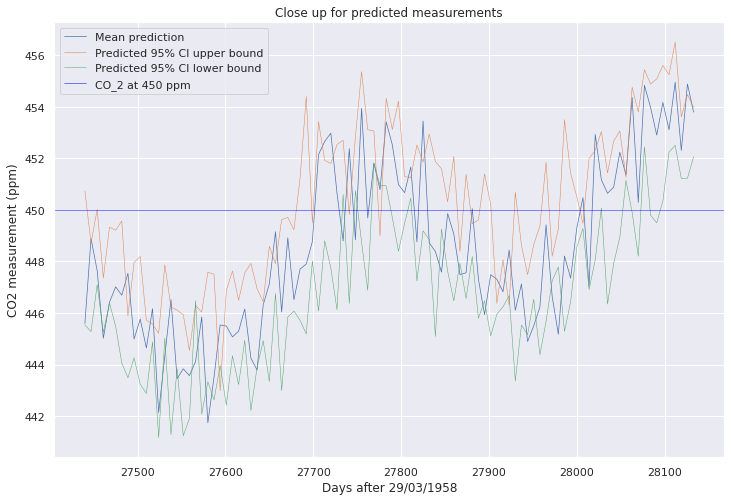

In [134]:
#closeups for the predicted data 
plt.figure(figsize=(12,8))
plt.plot(new_time[650:750],pred_mean[650:750],label='Mean prediction',linewidth=0.7)
plt.plot(new_time[650:750],pred_upper[650:750],label='Predicted 95% CI upper bound',linewidth=0.5)
plt.plot(new_time[650:750],pred_lower[650:750],label='Predicted 95% CI lower bound',linewidth=0.5)
plt.axhline(y=450,color='blue',label='CO_2 at 450 ppm',linewidth=0.5)
plt.title('Close up for predicted measurements')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()

In [172]:
len(new_time)

2052

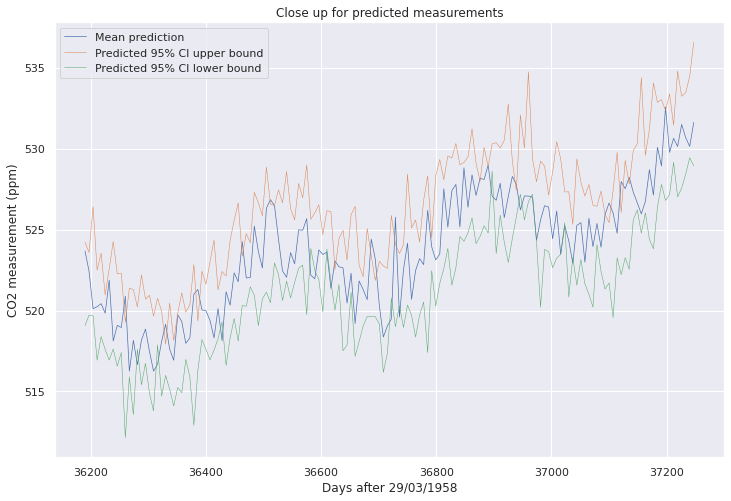

In [174]:
plt.figure(figsize=(12,8))
plt.plot(new_time[1900:2052],pred_mean[1900:2052],label='Mean prediction',linewidth=0.7)
plt.plot(new_time[1900:2052],pred_upper[1900:2052],label='Predicted 95% CI upper bound',linewidth=0.5)
plt.plot(new_time[1900:2052],pred_lower[1900:2052],label='Predicted 95% CI lower bound',linewidth=0.5)
plt.title('Close up for predicted measurements')
plt.ylabel('CO2 measurement (ppm)')
plt.xlabel('Days after 29/03/1958')
plt.legend()
plt.show()